In [1]:
import triton
import triton.language as tl
import torch
from torch import Tensor
from math import ceil

In [2]:
@triton.jit
def vec_vec_prod_kernel(a_pointer, b_pointer, out_pointer, num_elements, block_size:tl.constexpr):

    pid = tl.program_id(axis=0)
    pointer_offset = pid * block_size

    pointers = pointer_offset + tl.arange(0, block_size)
    mask = pointers < num_elements

    a = tl.load(a_pointer+pointers, mask)
    b = tl.load(b_pointer+pointers, mask)

    res = tl.sum(a * b,axis=0)

    tl.atomic_add(out_pointer, res)


def vec_vec_prod_triton(a:Tensor, b:Tensor, block_size:int=1024) -> float:
    assert a.device == b.device


    num_elements = a.shape[0]
    grid = (ceil(num_elements / block_size)),

    out = torch.tensor(0.).to(a.device)
    vec_vec_prod_kernel[grid](a,b,out,num_elements, block_size)

    return out.item()


DEVICE = torch.device('cuda')
a = torch.tensor([.1,.2,.3]).to(DEVICE)
b = torch.tensor([.1,.2,.3]).to(DEVICE)

out = vec_vec_prod_triton(a, b)
print(out)

print(a @ b)





0.14000001549720764
tensor(0.1400, device='cuda:0')


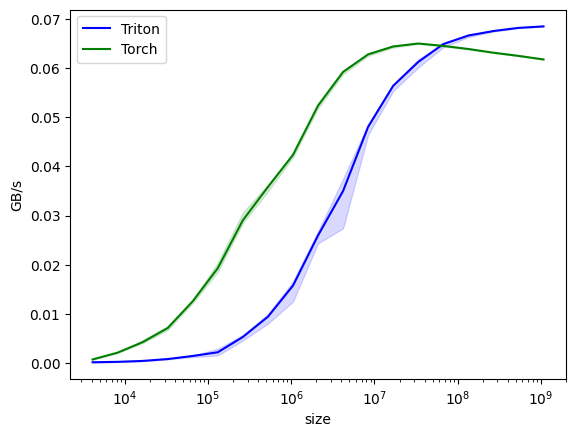

vector-add-performance:
            size    Triton     Torch
0   4.096000e+03  0.000082  0.000650
1   8.192000e+03  0.000164  0.002040
2   1.638400e+04  0.000351  0.004180
3   3.276800e+04  0.000732  0.007062
4   6.553600e+04  0.001366  0.012526
5   1.310720e+05  0.002116  0.019275
6   2.621440e+05  0.005237  0.029050
7   5.242880e+05  0.009362  0.035812
8   1.048576e+06  0.015701  0.042363
9   2.097152e+06  0.025932  0.052418
10  4.194304e+06  0.034995  0.059282
11  8.388608e+06  0.048087  0.062857
12  1.677722e+07  0.056442  0.064470
13  3.355443e+07  0.061306  0.065066
14  6.710886e+07  0.064943  0.064579
15  1.342177e+08  0.066698  0.063951
16  2.684355e+08  0.067610  0.063195
17  5.368709e+08  0.068255  0.062549
18  1.073742e+09  0.068559  0.061821


In [3]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['size'],  # Argument names to use as an x-axis for the plot.
        x_vals=[2**i for i in range(12, 31, 1)],  # Different possible values for `x_name`.
        x_log=True,  # x axis is logarithmic.
        line_arg='provider',  # Argument name whose value corresponds to a different line in the plot.
        line_vals=['triton', 'torch'],  # Possible values for `line_arg`.
        line_names=['Triton', 'Torch'],  # Label name for the lines.
        styles=[('blue', '-'), ('green', '-')],  # Line styles.
        ylabel='GB/s',  # Label name for the y-axis.
        plot_name='vector-add-performance',  # Name for the plot. Used also as a file name for saving the plot.
        args={},  # Values for function arguments not in `x_names` and `y_name`.
    ))


def benchmark(size, provider):
    x = torch.rand(size, device=DEVICE, dtype=torch.float32)
    y = torch.rand(size, device=DEVICE, dtype=torch.float32)
    quantiles = [0.5, 0.2, 0.8]
    if provider == 'torch':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: x @ y, quantiles=quantiles)
    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: vec_vec_prod_triton(x, y, 2048), quantiles=quantiles)
    gbps = lambda ms: 2 * size * 1e-12 / (ms * 1e-3)
    return gbps(ms), gbps(max_ms), gbps(min_ms)

benchmark.run(print_data=True, show_plots=True)